Tentative de simulation plus proche des plages

In [1]:
from parcels import (FieldSet, AdvectionRK4, BrownianMotion2D, plotTrajectoriesFile, Field,
                     ParticleSet, JITParticle, Variable, ErrorCode)
import numpy as np
import scipy as sc
import math
from datetime import timedelta, datetime
from operator import attrgetter
import pandas as pd
import copy_plottrajectoriesfile as cpt
import matplotlib.animation as animation
import imageio #to make .gif out of multiple .png
import matplotlib.pyplot as plt
import scipy.io as sio #to load matlab file
import xarray as xr
from shapely.geometry import Point, Polygon

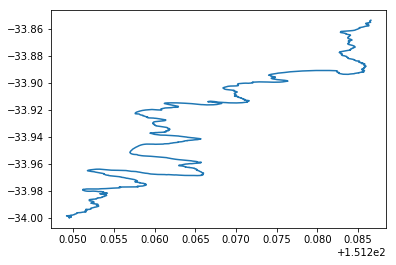

In [2]:
def LimitBoundaries(lon_i, lat_i, lon_min): #return lon and lat for every lon>lon_min
    newlat=[]
    newlon=[]
    for i in range (0,len(lat_i)):
        if (lon_i[i]>lon_min):
            newlat.append(lat_i[i])
            newlon.append(lon_i[i])
    return newlon, newlat

"""Load & read Matlab boundaries file"""

mat_boundaries = sio.loadmat('../../nsw_boundaries/coast_beaches.mat')

#mat_boundaries

lat_nsw=mat_boundaries['lat_coast_poly'][0]
lon_nsw=mat_boundaries['lon_coast_poly'][0]

plt.plot(lon_nsw, lat_nsw)
#plt.show()

"""create boundaries polygon"""

boundaries_coords = [(lat_nsw[i],lon_nsw[i]) for i in range(0,len(lat_nsw))]
boundaries_coords.append((-33.8535679969999,151.249548000001)) #add a point to close the polygon
poly_boundaries=Polygon(boundaries_coords)

In [3]:
"""
Load u_cur data 
"""

file_name = '../raw_imos_current_data/file_adcp_SYD100_2016_2019.csv'
file=pd.read_csv(file_name)

date=[datetime.strptime(day, '%Y-%m-%d') for day in file.DATE]

u_cur=file.UCUR_ROT_int
v_cur=file.VCUR_ROT_int
time=file.TIME
date_new=date[1095:1105]
time_new=time[1095:1105]
u_new=u_cur[1095:1105]
v_new=v_cur[1095:1105]

In [4]:
long=np.arange(np.min(lon_nsw),151.4, 4.700800002410688e-05)
lati=np.arange(np.min(lat_nsw),np.max(lat_nsw), 0.000111000000202921)

size2D=(len(lati),len(long))

u=[u*np.ones(size2D) for u in u_new]
v=[v*np.ones(size2D) for v in v_new]

UCUR=xr.DataArray(u,
                dims=['time','lat','lon'],
                coords={'time':date_new,
                       'lat':lati,
                       'lon':long})    

VCUR=xr.DataArray(v,
                dims=['time','lat','lon'],
                coords={'time':date_new,
                       'lat':lati,
                       'lon':long})  

#add to the existing dataset
ds=UCUR.to_dataset(name='UCUR')
ds['VCUR']=VCUR

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

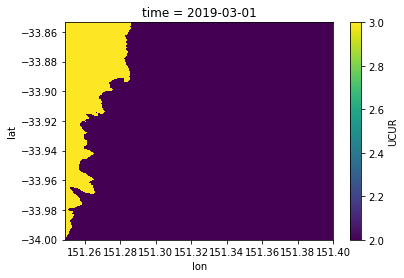

In [5]:
"""
create mask
"""

tru=np.ones((len(lati), len(long)))
for i in range(len(lati)):
    print(i)
    for j in range(len(long)):
        point=Point(lati[i],long[j])
        tru[i][j]=point.within(poly_boundaries)

mask_ocean = 2 * np.ones((len(lati), len(long))) * np.isfinite(ds.UCUR.isel(time=0))
mask_land =  1 * np.ones((len(lati), len(long))) * tru

mask_array = mask_ocean + mask_land
mask_array.plot()

In [6]:
ds.coords['MASK'] = (('lat', 'lon'), mask_array) 
ds['u_cur_masked']=ds['UCUR'].where(ds.MASK==2)
ds['v_cur_masked']=ds['VCUR'].where(ds.MASK==2)

In [7]:
"""
Create wind data
"""
uu = [-2.53, -3.105, -4.488, -4.742, 0.842, 0.6968, -2.594, 1.084, -1.2559, -0.0133]
vv = [-2.68, -3.877, -6.401, -6.122, 1.197, 5.0443, -4.875, 3.6347, -2.6456, 3.3733]
#to replace with real wind data

size2D = (len(lati),len(long))

#size3D = (10,2200,2200)
u_values=[u*np.ones(size2D) for u in uu]
v_values=[v*np.ones(size2D) for v in vv]


u_wind=xr.DataArray(u_values,
                dims=['time','lat','lon'],
                coords={'time':date_new,
                        'lat':lati,
                        'lon':long},)     

v_wind=xr.DataArray(v_values,
                dims=['time','lat','lon'],
                coords={'time':date_new,
                        'lat':lati,
                        'lon':long},)   

#add to the existing dataset
ds['u_wind']=u_wind
ds['v_wind']=v_wind

#Mask data on land
ds['u_wind_masked']=ds['u_wind'].where(ds.MASK==2)
ds['v_wind_masked']=ds['v_wind'].where(ds.MASK==2)


In [8]:
"""
Create fieldset with extrapolated cur data, wind data, brownian motion
"""

variables = {'U' : 'u_cur_masked', #U refers to U_cur bc AdvectionRK4 needs U
            'V' : 'v_cur_masked',
            'U_wind':'u_wind_masked',
            'V_wind':'v_wind_masked'}
dimensions = {'lon' : 'lon',
              'lat' : 'lat',
              'time' : 'time'} 

fieldset = FieldSet.from_xarray_dataset(ds, variables, dimensions, allow_time_extrapolation=True)

In [9]:
import math #bc kernel cant handle numpy
def WindDrag(particle, fieldset, time):

    #constants
    S_x = 1.12e-4 #m^2 (from Daniel Lee)
    S_y = 5.5e-4 #m^2 (from Daniel Lee)
    S_w = 3.78e-4 #m^2 (from Daniel Lee)
    rho_a = 1.225 #kg.m^-3
    rho_w = 1030 #kg.m^-3
    
    #variables
    C_ax = 0.1
    C_ay = 1
    C_w = 1
    gamma = 0*math.pi/180
    
    
    u_wind = fieldset.U_wind[time, particle.depth, particle.lat, particle.lon]
    v_wind = fieldset.V_wind[time, particle.depth, particle.lat, particle.lon]

    coeff = (math.sqrt((S_x*C_ax)**2+ (S_y*C_ay)**2))/(S_w*C_w)
    vel_wind = math.sqrt((u_wind)**2 + (v_wind)**2)
    dir_wind = math.atan2(u_wind,v_wind) 
    vel_bb = math.fabs(vel_wind)*math.sqrt(rho_a/rho_w*coeff)
    
    theta = dir_wind + gamma #wind_dir in oceano, gamma : angle between wind course and BB course
    
    diff_x += (math.sin(theta)*vel_bb)*particle.dt #in meters
    diff_y += (math.cos(theta)*vel_bb)*particle.dt #in meters
    
    particle.lon += diff_x/111e3 #in deg
    particle.lat += diff_y/111e3 #in deg

In [247]:
%matplotlib qt
import math

def DeleteParticle(particle, fieldset, time):
    particle.delete()
    


lons=[151.36,151.36,151.36,151.36,151.36,151.36,151.36,151.348,151.34,151.33,151.32,151.31,151.3]
lats=[-33.99,-33.96,-33.94,-33.92,-33.9,-33.88,-33.86,-33.86,-33.86,-33.86,-33.86,-33.86,-33.86]
pset = ParticleSet.from_list(fieldset=fieldset,
                             pclass=JITParticle,
                             lon=lons,
                             lat=lats,
                             time=date_new[0],
                             repeatdt=timedelta(days=1))

kernels=pset.Kernel(AdvectionRK4)+pset.Kernel(WindDrag)
pset.show(show_time=10)
pset.execute(kernels, 
             runtime=timedelta(days=10),  #days=30 idealement
             dt=timedelta(hours=1), 
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
             output_file=pset.ParticleFile(name="forc1d0.nc", outputdt=timedelta(hours=5)))

#print(pset)
#pset.show(field='vector',vmax=3.,land=False)

INFO: Compiled JITParticleAdvectionRK4WindDrag ==> /tmp/parcels-13529592/1b84d4ffda820cd45b1899a5ea9106f8.so


In [223]:
date_new[0]

datetime.datetime(2019, 3, 1, 0, 0)

In [236]:
"""
Dataset for a time fixed to plot trajectories with U field
"""
ds.isel(time=0).to_netcdf('datasset.nc')

plotTrajectoriesFile('back0.nc',
                     tracerfile='datasset.nc',
                     tracerlon='lon',
                     tracerlat='lat',
                     tracerfield='u_cur_masked');

In [19]:

plotTrajectoriesFile('tjkjR.nc', mode='hist2d');

In [167]:
mask_array.plot()

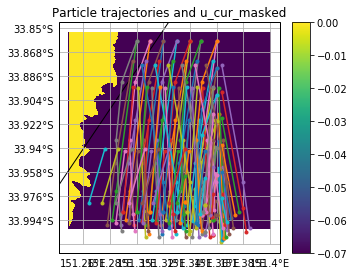

In [248]:
%matplotlib inline
#Cay = 1 
#ang = -40deg
plotTrajectoriesFile('forc1d-40.nc',
                     tracerfile='datasset.nc',
                     tracerlon='lon',
                     tracerlat='lat',
                     tracerfield='u_cur_masked');

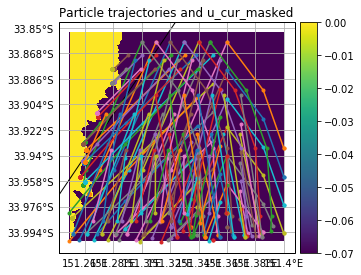

In [238]:
%matplotlib inline
#Cay = 1 
#ang = 40deg
plotTrajectoriesFile('forc1d40.nc',
                     tracerfile='datasset.nc',
                     tracerlon='lon',
                     tracerlat='lat',
                     tracerfield='u_cur_masked');

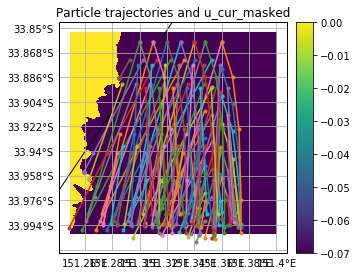

In [244]:
%matplotlib inline
#Cay = 1 
#ang = 0deg
plotTrajectoriesFile('forc1d0.nc',
                     tracerfile='datasset.nc',
                     tracerlon='lon',
                     tracerlat='lat',
                     tracerfield='u_cur_masked');

In [ ]:
"""
lon=[154.5,154.5,154.5,154.5,154,153.2,152.5,151.7,153.2,154], 
lat=[-31.5,-32.5,-33.5,-34.5,-34.5,-34.5,-34.5,-34.5,-31.5,-31.5],
time=[0,0,0,0,0,0,0,0,0,0]) 

pset = ParticleSet.from_line(fieldset=fieldset,
                             size = 10,            # releasing 5 particles
                             start = (151.3, -33.868),   # releasing on a line: the start longitude and latitude
                             finish = (151.3, -33.976),
                             time = date_new[8],
                             pclass = JITParticle)
                             
                             

pset= ParticleSet.from_field(fieldset=fieldset,
                             pclass = JITParticle,
                             start_field=fieldset.U,
                             time=date_new[7],
                             size=200)
"""